In [1]:
# for testing whether CPU or GPU is faster on a problem
NO_GPU = False

if NO_GPU:
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as kl
from keras.datasets import reuters
from keras import preprocessing

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def build_model(*layers, verbose=False,
               optimizer='adam', loss='categorical_crossentropy', metrics=['acc'],
               compile_kwargs={}):
    
    model = keras.models.Sequential()
    
    for layer in layers:
        model.add(layer)
        
    if verbose:
        print("Model summary:")
        model.summary()
    
    for kw in ('optimizer', 'loss', 'metrics'):
        if not kw in compile_kwargs:
            compile_kwargs[kw] = locals()[kw]
    model.compile(**compile_kwargs)
    
    return model

In [3]:
def plot_history(history, figsize=(15,4), title='', columns=2, start_x_from=0):
    """Graphs a history for each key (combines validation and training keys into one plot).
    
    start_x_from=N skips the first N entries.
    
    History can be a whole training history class or just a dict."""
    
    if hasattr(history, 'history'): # full history given
        history = history.history   # only that history is enough
        
    assert hasattr(history, 'keys')
    keys = [key for key in history.keys() if not key.startswith("val_")]
    assert keys # there is one at least
    epochs = list(range(1,len(history[keys[0]])+1)) # all should have the same size list
    
    rows = np.ceil(len(keys)/columns).astype('int')
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    i = 1
    for key in sorted(keys):
        valkey = "val_" + key
        fig.add_subplot(rows, columns, i)
        i += 1
        plt.plot(epochs[start_x_from:], history[key][start_x_from:], label="Training " + key,
                 marker='.', color='#00A287', linestyle='')
        
        late_avg = np.mean(history[key][(len(history[key]) * 90) // 100 : ])
        plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                 color="#74E600", label='Mean {:.3f}'.format(late_avg))
        if valkey in history:
            plt.plot(epochs[start_x_from:], history[valkey][start_x_from:], label='Validation ' + key,
                    marker='+', color='#DF004F', linestyle='')
            
            late_avg = np.mean(history[valkey][(len(history[valkey]) * 90) // 100 : ])
            plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                     color="#FF6700", label='Mean {:.3f}'.format(late_avg))
        plt.legend()
        
    plt.show()

In [8]:
MAX_SEQUENCE_LENGTH = 200
DICTIONARY_SIZE = 4000
SKIP_TOP_WORDS = 3

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=DICTIONARY_SIZE,
    skip_top=SKIP_TOP_WORDS
)

#train_data = np.array([s[:-1] for s in train_data])

train_data = preprocessing.sequence.pad_sequences(train_data, maxlen=MAX_SEQUENCE_LENGTH, truncating='post')
test_data  = preprocessing.sequence.pad_sequences(test_data, maxlen=MAX_SEQUENCE_LENGTH, truncating='post')

train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 16)           64000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 46)                147246    
Total params: 211,246
Trainable params: 211,246
Non-trainable params: 0
_________________________________________________________________
Train on 7185 samples, validate on 1797 samples
Epoch 1/20
7185/7185 [==============================] - 1s 94us/step - loss: 2.4040 - acc: 0.3653 - val_loss: 1.9696 - val_acc: 0.4825
Epoch 2/20
7185/7185 [==============================] - 0s 50us/step - loss: 1.7551 - acc: 0.5318 - val_loss: 1.6524 - val_acc: 0.5793
Epoch 3/20
7185/7185 [==============================] - 0s 49us/ste

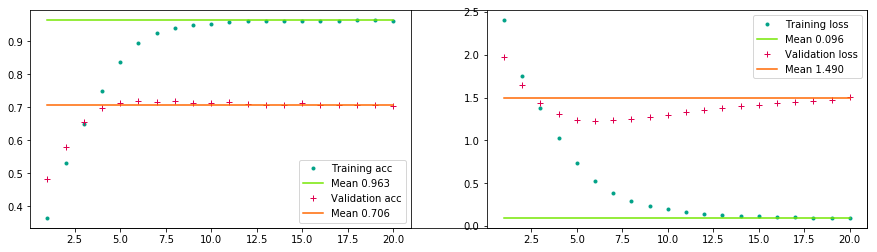

In [9]:
simple_embd_model = build_model(
    kl.Embedding(DICTIONARY_SIZE, 16, input_length=MAX_SEQUENCE_LENGTH),
    kl.Flatten(),
    kl.Dense(46, activation='softmax'),
    verbose=1
)


simple_embd_history = simple_embd_model.fit(
    train_data,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

plot_history(simple_embd_history)

In [14]:
simple_embd_model = build_model(
    kl.Embedding(DICTIONARY_SIZE, 16, input_length=MAX_SEQUENCE_LENGTH),
    kl.GRU(MAX_SEQUENCE_LENGTH * 3 // 2, return_sequences=False),
   # kl.Flatten(),
    kl.Dense(46, activation='softmax'),
    verbose=1
)


simple_embd_history = simple_embd_model.fit(
    train_data,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 16)           64000     
_________________________________________________________________
gru_5 (GRU)                  (None, 300)               285300    
_________________________________________________________________
dense_7 (Dense)              (None, 46)                13846     
Total params: 363,146
Trainable params: 363,146
Non-trainable params: 0
_________________________________________________________________
Train on 7185 samples, validate on 1797 samples
Epoch 1/20
1792/7185 [======>.......................] - ETA: 16s - loss: 3.5247 - acc: 0.3560

KeyboardInterrupt: 

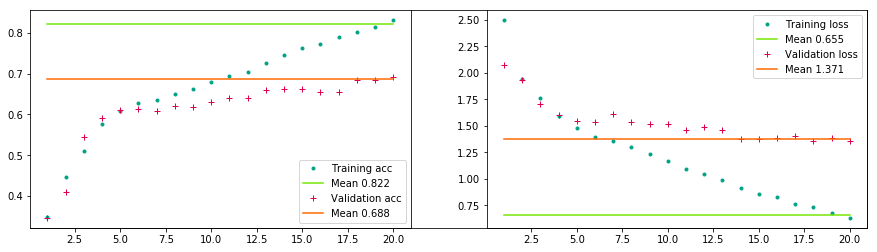

In [11]:
plot_history(simple_embd_history)